# Siamese CNN - regularizing classification with verification loss
- ## bulk of siamese cnn code: https://www.pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/
- ## inspiration to make feature maps invaraint wrt. rotation by regularizing with their similarity loss comes from paper: https://www.mdpi.com/2072-4292/13/4/569 (specifically from Figure 2)
- ## also from paper here: https://jivp-eurasipjournals.springeropen.com/track/pdf/10.1186/s13640-018-0398-z.pdf (figure 1)


## Results are similar to a simple CNN trained on normal images, and then tested on rotated images, thus not satisfactory

In [199]:
from tensorflow.keras import datasets, layers, models, backend as K

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [6]:
(x, y), (x_t, y_t) = datasets.mnist.load_data()
x = x / 255.0
x_t = x_t / 255.0

x = np.expand_dims(x, axis=-1)
x_t = np.expand_dims(x_t, axis=-1)

## Making positive and negative pairs for the siamese verification training
### Also here random rotations are applied

In [205]:
def make_pairs(images, labels):
    """Pairs of positive and negative pairs."""
    pairImages = []
    pairLabels = []
    
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    
    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        
        # Randomly pick an image of the same label
        idxB = np.random.choice(idx[label])
        
        # APPLY random rotation to positive pair b image
        posImage = tfa.image.rotate(images[idxB], np.random.uniform(-np.pi/2., np.pi/2.))
        
        # Add the positive pair
        pairImages.append([currentImage, posImage])
        pairLabels.append(np.array([label, label, 1])) # 1, as they are similar (true)
       
        # Randomly select negative image (different label)
        negIdx = np.where(labels != label)[0]
        negImgId = np.random.choice(negIdx)
        negImage = images[negImgId]
        
        # Add the negative pair
        pairImages.append([currentImage, negImage])
        pairLabels.append(np.array([label, labels[negImgId], 0]))  # 0, as they are different (false)
        
    return np.asarray(pairImages), np.asarray(pairLabels)        

In [273]:
pair_train, label_train = make_pairs(x, y)
pair_test, label_test = make_pairs(x_t, y_t)

## Core of the Siamese CNN network

In [108]:
def build_siamese_model(inputShape, classes=10):
    # Specify input shape for feature extractore network
    inputs = layers.Input(inputShape)
    
    # CONV => RELU => POOL => DROPOUT layers
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Dropout(.3)(x)
    
    # CONV => RELU => POOL => DROPOUT layers
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Dropout(.3)(x)
    
    # GLOBAL MAX POOL => DENSE
    pooledOutput = layers.GlobalMaxPool2D()(x)
    outputs = layers.Dense(classes)(pooledOutput)
    
    # Build model
    model = models.Model(inputs, outputs)
    
    return model

## Computing similarity/verification loss between the images of the pairs by Euclidean dist

In [29]:
def euclidean_distance(vectors):
    # Unpack vectors
    (feats_a, feats_b) = vectors
    
    # Compute sum of squared distance between vectors
    sum_squared = K.sum(K.square(feats_a - feats_b), axis=1, keepdims =True)
    
    # Return euclidean dist. between the vectors
    return K.sqrt(K.maximum(sum_squared, K.epsilon())) 

# Constructing the final siamese model and tranining
- ## Trying to mix the losses in 2 ways, first function train_step_naive just adds them together, the other 'train_step_regularize' tries to combine only little of the verification loss

In [303]:
# Set up CNN network
IMG_SHAPE = (28, 28, 1)

naive_model = build_siamese_model(IMG_SHAPE)
reg_model = build_siamese_model(IMG_SHAPE)

batch_size = 64
# Construct data generator
train_data = ((pair_train[i:i+batch_size], label_train[i:i+batch_size]) for i in range(0, x.shape[0]-batch_size, batch_size))

NUM_EPOCHS = 3
beta = .1 # 10% of verification loss

optimizer = tf.keras.optimizers.Adam(0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_verification_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Function to mix lossess from classification and from verification/siamese similarity
# Below here is just simple addition of all losses
@tf.function
def train_step_naive(model, inputs, labels): # Naive addition of losses
    with tf.GradientTape() as tape:
        # Compute classification features
        feats_a = model(inputs[:, 0], training=True)
        feats_b = model(inputs[:, 1], training=True)
        
        # Verification distance features
        distance = euclidean_distance([feats_a, feats_b])
        
        #regularization_loss = tf.math.add_n(model.losses)  - model has no regularization internally
        
        # Compute classification loss
        pred_a_loss = loss_fn(labels[:, 0], feats_a)
        pred_b_loss = loss_fn(labels[:, 1], feats_b)
        
        # Compute verification loss
        pred_verification = loss_verification_fn(labels[:, 2], distance)
        
        # Mix classification lossess with verification loss
        total_loss = (pred_a_loss + pred_b_loss) + pred_verification

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
# Function to mix losses by attempting to 'regularize'
@tf.function
def train_step_regularize(model, inputs, labels): # Trying to mix verification loss by regularizer
    with tf.GradientTape() as tape: 
        # Compute classification features
        feats_a = model(inputs[:, 0], training=True)
        feats_b = model(inputs[:, 1], training=True)
        
        # Verification distance features
        distance = euclidean_distance([feats_a, feats_b])
        
        # Compute classification loss
        pred_a_loss = loss_fn(labels[:, 0], feats_a)
        pred_b_loss = loss_fn(labels[:, 1], feats_b)
        
        # Compute verification loss
        pred_verification = loss_verification_fn(labels[:, 2], distance)
        
        regularizers = tf.keras.regularizers.L2(1)(pred_verification)
        
        # Mix classification lossess with verification loss
        total_loss = pred_a_loss + beta * pred_verification

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    
# Train a model with each attempt of mixing the losses
for epoch in range(NUM_EPOCHS):
    for inputs, labels in train_data:
        train_step_naive(naive_model, inputs, labels)
        train_step_regularize(reg_model, inputs, labels)
    print("Finished epoch", epoch)

Finished epoch 0
Finished epoch 1
Finished epoch 2


## Sanity check of rotation

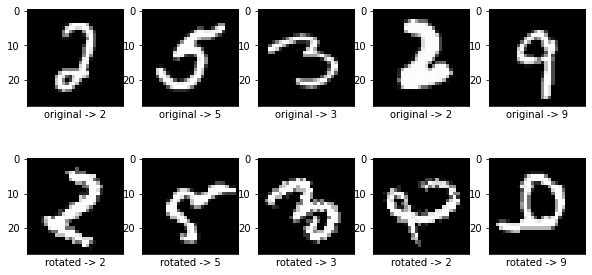

In [297]:
plt.figure(figsize=(10, 5))

for i in range(5):
    random_id = np.random.randint(0, 9999)
    
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pair_test[::2, 0][random_id], cmap=plt.cm.binary_r) # positive pair (every 2nd), original
    plt.xlabel(f"original -> {y_t[random_id]}")
    
    plt.subplot(2, 5, i+6)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pair_test[::2, 1][random_id], cmap=plt.cm.binary_r) # positive pair (every 2nd), rotated
    plt.xlabel(f"rotated -> {y_t[random_id]}")
plt.show()

## Accuraccy for naive mixing of losses

In [304]:
accuracy = np.mean(naive_model.predict(pair_test[::2, 0]).argmax(axis=1) == y_t)*100
accuracy_r = np.mean(naive_model.predict(pair_test[::2, 1]).argmax(axis=1) == y_t)*100
print(accuracy, accuracy_r)

94.71000000000001 54.22


## Accuraccy for naive 'regularizing' of losses

In [306]:
accuracy = np.mean(reg_model.predict(pair_test[::2, 0]).argmax(axis=1) == y_t)*100
accuracy_r = np.mean(reg_model.predict(pair_test[::2, 1]).argmax(axis=1) == y_t)*100
print(accuracy, accuracy_r)

94.26 42.26
